# Abstract

The aim of this notebook is to illustrate how analysts and data scientists can take advantage of [Vortexa's Python SDK](https://github.com/VorTECHsa/python-sdk) to gain real-time market insights of the oil industry and use Vortexa's data to build powerful predictive models. We will focus on United States Crude oil exports, which have skyrocketed the last couple of years and constitute on of the main drivers of the whole oil industry. In the first part of the notebook, we will familiarize with using the SDK and do an initial **exploratory analysis** of our data to get a sense of their nature. In the second part, we will build a **forecasting model** to predict US Crude exports for the next couple of months. Let's start!

PS: Please note that the results on this notebook represent Vortexa's data as of 24th February 2020. These data are constantly evolving, refined and improved, therefore some (small) deviations in the numbers presented should be expected in future runs of the notebook. 

In [1]:
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from vortexasdk import CargoMovements, Geographies, Products

warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 200

# Exploratory Analysis

## Fetching Data

The first step is to define the limits of the time period we are interested to look at. Note, that the SDK can return a maximum of 4 years of historical data. In addition, since every entity that lives in Vortexa API is associated with a unique ID, we will need to retrieve the relevant IDs for our analysis. 

In [2]:
# Define filter limits
END_DATE = datetime(2020,2,1)
START_DATE = datetime(2016,2,1)
print("Start date: {}".format(START_DATE))
print("End date: {}".format(END_DATE))

Start date: 2016-02-01 00:00:00
End date: 2020-02-01 00:00:00


In [3]:
# Find United States ID
us = [g.id for g in Geographies().search("united states").to_list() if "country" in g.layer]
print("United States polygon id: {}".format(us[0]))

2020-02-26 10:50:24,794 vortexasdk.operations — INFO — Searching Geographies with params: {'term': ['united states']}
2020-02-26 10:50:24,796 vortexasdk.client — INFO — Creating new VortexaClient
2020-02-26 10:50:25,593 vortexasdk.client — INFO — 1 Results to retreive. Sending 1 post requests in parallel using 6 threads.
United States polygon id: 2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963


In [4]:
# Check we've only got one ID for US
assert len(us) == 1

In [5]:
# Find Crude ID
crude = [p.id for p in Products().search("crude").to_list() if p.name=="Crude"]
crude

2020-02-26 10:50:26,151 vortexasdk.operations — INFO — Searching Products with params: {'term': ['crude'], 'ids': [], 'product_parent': [], 'allowTopLevelProducts': True}
2020-02-26 10:50:26,947 vortexasdk.client — INFO — 8 Results to retreive. Sending 1 post requests in parallel using 6 threads.


['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653']

In [6]:
# Check we've only got one Crude ID
assert len(crude) == 1

In [7]:
# Define the set of columns you want to be returned. For the complete set of available columns check the link:

#                   https://vortechsa.github.io/python-sdk/endpoints/cargo_movements/#notes

# Note that not all of the columns defined below are directly necessary for our analysis, but is a good opportunity 
# for beginner users of the SDK to get a grasp of the highly non-flat structure of the data and the level of detail
# the data can dig into.

required_columns = [
        # A cargo movement can be carried by multiple vessels across various STS transfers. You can find all the vessels that
        # the cargo was onboard by inspecting the 'vessels.0', 'vessels.1' columns etc.
        # The 'vessels.0' columns shows the primary vessel associated with the cargo movement
        "cargo_movement_id",
        "vessels.0.name",
        "vessels.0.imo",
        "vessels.0.vessel_class",
        "vessels.0.dwt",
        "vessels.1.name",
        "vessels.1.imo",
        "vessels.1.vessel_class",
        "vessels.1.dwt",
        "vessels.2.name",
        "vessels.2.imo",
        "vessels.2.vessel_class",
        "vessels.2.dwt",
        # Bring the loading Geography and Timestamps
        "events.cargo_port_load_event.0.location.terminal.label",
        "events.cargo_port_load_event.0.location.port.label",
        "events.cargo_port_load_event.0.location.country.label",
        "events.cargo_port_load_event.0.location.trading_region.label",
        "events.cargo_port_load_event.0.location.shipping_region.label",
        "events.cargo_port_load_event.1.location.port.label",
        "events.cargo_port_load_event.2.location.port.label",
        "events.cargo_port_load_event.0.start_timestamp",
        "events.cargo_port_load_event.0.end_timestamp",
        "events.cargo_port_load_event.1.end_timestamp",
        "events.cargo_port_load_event.2.end_timestamp",
        # Bring STS associated info
        "events.cargo_sts_event.0.start_timestamp",
        "events.cargo_sts_event.0.location.sts_zone.label",
        "events.cargo_sts_event.1.start_timestamp",
        "events.cargo_sts_event.1.location.sts_zone.label",
        "events.cargo_sts_event.2.start_timestamp",
        "events.cargo_sts_event.2.location.sts_zone.label",
        # Bring the discharge Geography and Timestamps
        "events.cargo_port_unload_event.0.location.terminal.label",
        "events.cargo_port_unload_event.0.location.port.label",
        "events.cargo_port_unload_event.0.location.country.label",
        "events.cargo_port_unload_event.0.location.region.label",
        "events.cargo_port_unload_event.0.location.trading_subregion.label",
        "events.cargo_port_unload_event.0.location.shipping_region.label",
        "events.cargo_port_unload_event.0.location.trading_region.label", 
        "events.cargo_port_unload_event.0.start_timestamp",
        "events.cargo_port_unload_event.0.end_timestamp",
        "events.cargo_port_unload_event.1.location.port.label",
        "events.cargo_port_unload_event.1.end_timestamp",
        "events.cargo_port_unload_event.2.location.port.label",
        "events.cargo_port_unload_event.2.end_timestamp",
        #Bring any corporate information associated with the primary vessel
        "vessels.0.corporate_entities.charterer.label",
        # Bring product information and quantity
        "product.grade.label",
        "product.category.label",
        "product.group_product.label",
        "product.group.label",
        "quantity",
        # Is the vessel in transit, has it already discharged, or is it in floating storage?
        "status"
    ]


# Define a function to perform some basic manipulations in the data for ease of use
def prepare_cms(cms, ignore_intra = True):
    """ 
    Performs some basic data manipulation to the cargo movements DataFrame. By default, intra cargo movements,
    i.e. cargo movements that start and end in the same country are filtered out.
    """   
    # Convert date column to pandas datetime type
    cols = [c for c in cms.columns if "timestamp" in c]
    for c in cols:
        cms[c] = pd.to_datetime(cms[c]).dt.tz_localize(None)
        
    # Rename columns for ease of use
    cms = cms.rename(columns = {"events.cargo_port_load_event.0.start_timestamp": "loading_timestamp",
                                "events.cargo_port_load_event.0.end_timestamp": "start_timestamp",
                                "events.cargo_port_unload_event.0.start_timestamp": "unloading_timestamp",
                                "events.cargo_port_unload_event.0.end_timestamp": "end_timestamp",
                                "events.cargo_port_load_event.0.location.port.label": "loading_port",
                                "events.cargo_port_load_event.0.location.trading_region.label": "loading_trading_region",
                                "events.cargo_port_load_event.0.location.country.label": "loading_country",
                                "events.cargo_port_unload_event.0.location.country.label": "unloading_country",
                                "product.category.label": "product_category"
                               })
        
    # Calculate loading week and month
    cms["loading_week"] = cms["start_timestamp"].map(lambda x: x.to_period("W").start_time.date() if not pd.isnull(x) else x)
    cms["loading_month"] = cms["start_timestamp"].map(lambda x: x.to_period("M").start_time.date() if not pd.isnull(x) else x)
    
    # Depending on user input keep or ignore intra cargo movements, i.e. movements that start and end in the 
    # same country
    if ignore_intra:
        cms = cms.loc[cms["loading_country"] != cms["unloading_country"]]
    
    return cms

In [8]:
# Query the SDK and convert result to DataFrame
cms = CargoMovements().search(
        filter_activity = "loading_end",
        filter_origins = us,
        filter_products = crude,
        filter_time_min = START_DATE,
        filter_time_max = END_DATE,
        cm_unit = "b"
    ).to_df(columns = required_columns)
print("Fetched {} crude cargo movements from United States".format(cms.shape[0]))
cms.head()

2020-02-26 10:50:27,542 vortexasdk.operations — INFO — Searching CargoMovements with params: {'filter_activity': 'loading_end', 'filter_time_min': '2016-02-01T00:00:00.000Z', 'filter_time_max': '2020-02-01T00:00:00.000Z', 'cm_unit': 'b', 'size': 500, 'filter_charterers': [], 'filter_owners': [], 'filter_products': ['6f11b0724c9a4e85ffa7f1445bc768f054af755a090118dcf99f14745c261653'], 'filter_vessels': [], 'filter_destinations': [], 'filter_origins': ['2d92cc08f22524dba59f6a7e340f132a9da0ce9573cca968eb8e3752ef17a963'], 'filter_storage_locations': [], 'filter_ship_to_ship_locations': [], 'filter_waypoints': [], 'disable_geographic_exclusion_rules': None}



Loading from API:   0%|          | 0/6948 [00:00<?, ?it/s]

2020-02-26 10:50:27,779 vortexasdk.client — INFO — 6948 Results to retreive. Sending 14 post requests in parallel using 6 threads.


Loading from API: 7000it [00:03, 1908.85it/s]                          


Fetched 6948 crude cargo movements from United States


,cargo_movement_id,vessels.0.name,vessels.0.imo,vessels.0.vessel_class,vessels.0.dwt,vessels.1.name,vessels.1.imo,vessels.1.vessel_class,vessels.1.dwt,vessels.2.name,vessels.2.imo,vessels.2.vessel_class,vessels.2.dwt,events.cargo_port_load_event.0.location.terminal.label,events.cargo_port_load_event.0.location.port.label,events.cargo_port_load_event.0.location.country.label,events.cargo_port_load_event.0.location.trading_region.label,events.cargo_port_load_event.0.location.shipping_region.label,events.cargo_port_load_event.1.location.port.label,events.cargo_port_load_event.2.location.port.label,events.cargo_port_load_event.0.start_timestamp,events.cargo_port_load_event.0.end_timestamp,events.cargo_port_load_event.1.end_timestamp,events.cargo_port_load_event.2.end_timestamp,events.cargo_sts_event.0.start_timestamp,events.cargo_sts_event.0.location.sts_zone.label,events.cargo_sts_event.1.start_timestamp,events.cargo_sts_event.1.location.sts_zone.label,events.cargo_sts_event.2.start_timestamp,events.cargo_sts_event.2.location.sts_zone.label,events.cargo_port_unload_event.0.location.terminal.label,events.cargo_port_unload_event.0.location.port.label,events.cargo_port_unload_event.0.location.country.label,events.cargo_port_unload_event.0.location.region.label,events.cargo_port_unload_event.0.location.trading_subregion.label,events.cargo_port_unload_event.0.location.shipping_region.label,events.cargo_port_unload_event.0.location.trading_region.label,events.cargo_port_unload_event.0.start_timestamp,events.cargo_port_unload_event.0.end_timestamp,events.cargo_port_unload_event.1.location.port.label,events.cargo_port_unload_event.1.end_timestamp,events.cargo_port_unload_event.2.location.port.label,events.cargo_port_unload_event.2.end_timestamp,vessels.0.corporate_entities.charterer.label,product.grade.label,product.category.label,product.group_product.label,product.group.label,quantity,status
0,eef9746529ceeae7acb5568f10ab743cbba3a6400d9a0a29ba66abe2d2e01c36,MINERVA ZOE,9255684,aframax,105330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Phillips 66 Beaumont Terminal,"Beaumont, TX [US]",United States,PADD 3 (US Gulf Coast),USAC/USGC,NaN,NaN,2018-02-13T17:59:47+0000,2018-02-18T18:47:19+0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dansk Statoil As,Kalundborg [DK],Denmark,Europe,Denmark,North Sea,North West Europe (excl. ARA),2018-03-13T00:11:48+0000,2018-03-14T06:16:58+0000,NaN,NaN,NaN,NaN,NaN,Bakken,Light-Sweet,Crude,Crude,422095,unloaded_state
1,ef16ba73f8914e697018a9a467c38aeac57cf26f7285f94dded6cc7a2b6334ca,SONANGOL RANGEL,9575541,suezmax,157755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oxy Ingleside,"Corpus Christi, TX [US]",United States,PADD 3 (US Gulf Coast),USAC/USGC,NaN,NaN,2019-12-09T19:48:16+0000,2019-12-11T20:44:09+0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cosmo Sekiyu,Sakai [JP],Japan,Asia,Japan,East Asia,East Asia,2020-02-18T04:35:00+0000,2020-02-19T01:23:15+0000,NaN,NaN,NaN,NaN,COSMO OIL,West Texas Midland (WTM),Light-Sweet,Crude,Crude,138507,unloaded_state
2,ef1f107c18eb3bdb1d7a16ca9e18e9ca641e68fbb56398a7c1a3dd9dff5f3efe,NS CONCEPT,9299707,aframax,109857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Houston Enterprise Terminal,"Houston, TX [US]",United States,PADD 3 (US Gulf Coast),USAC/USGC,NaN,NaN,2019-04-12T23:57:05+0000,2019-04-15T12:30:24+0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oiltanking Puerto Bahia,Cartagena [CO],Colombia,South America,NaN,South America,South America West Coast,2019-04-21T12:23:31+0000,2019-04-23T22:35:14+0000,NaN,NaN,NaN,NaN,CHEVRON,West Texas Intermediate (WTI),Light-Sweet,Crude,Crude,567402,unloaded_state
3,ef2f6505c12546db8624f47a87ab7e9dc280da532905ee8120dc8865c333a126,EAGLE TORRANCE,9360453,aframax,107123,C. INFINITY,9605190.0,vlcc_plus,313990.0,PIPER,9282481.0,aframax,114809.0,Nustar North Beach - Corpus Christi,"Corpus Christi, TX [US]",United States,PADD 3 (US Gulf Coast),USAC/USGC,NaN,NaN,2016-09-27T18:00:46+0000,2016-09-29T16:59:09+0000,NaN,NaN,2016-09-30T12:37:00+0000,Southtex Lightering/STS Zone [US],2016-11-18T03:04:13+0000,Linggi STS 

In [9]:
# Perform some basic operations in the DataFrame
cms = prepare_cms(cms, ignore_intra = True)
print("{:,} crude movements remaining after removing intra-movements".format(cms.shape[0]))
cms.sample(5)

4,618 crude movements remaining after removing intra-movements


,cargo_movement_id,vessels.0.name,vessels.0.imo,vessels.0.vessel_class,vessels.0.dwt,vessels.1.name,vessels.1.imo,vessels.1.vessel_class,vessels.1.dwt,vessels.2.name,vessels.2.imo,vessels.2.vessel_class,vessels.2.dwt,events.cargo_port_load_event.0.location.terminal.label,loading_port,loading_country,loading_trading_region,events.cargo_port_load_event.0.location.shipping_region.label,events.cargo_port_load_event.1.location.port.label,events.cargo_port_load_event.2.location.port.label,loading_timestamp,start_timestamp,events.cargo_port_load_event.1.end_timestamp,events.cargo_port_load_event.2.end_timestamp,events.cargo_sts_event.0.start_timestamp,events.cargo_sts_event.0.location.sts_zone.label,events.cargo_sts_event.1.start_timestamp,events.cargo_sts_event.1.location.sts_zone.label,events.cargo_sts_event.2.start_timestamp,events.cargo_sts_event.2.location.sts_zone.label,events.cargo_port_unload_event.0.location.terminal.label,events.cargo_port_unload_event.0.location.port.label,unloading_country,events.cargo_port_unload_event.0.location.region.label,events.cargo_port_unload_event.0.location.trading_subregion.label,events.cargo_port_unload_event.0.location.shipping_region.label,events.cargo_port_unload_event.0.location.trading_region.label,unloading_timestamp,end_timestamp,events.cargo_port_unload_event.1.location.port.label,events.cargo_port_unload_event.1.end_timestamp,events.cargo_port_unload_event.2.location.port.label,events.cargo_port_unload_event.2.end_timestamp,vessels.0.corporate_entities.charterer.label,product.grade.label,product_category,product.group_product.label,product.group.label,quantity,status,loading_week,loading_month
6028,5fb183365a5f497db067b7f90c3974a372960380abb40a49da0a4769dd86a1e2,GARIBALDI SPIRIT,9422835,aframax,109039,DRENEC,9723100.0,vlcc_plus,299999.0,NaN,NaN,NaN,NaN,Buckeye Terminal,"Corpus Christi, TX [US]",United States,PADD 3 (US Gulf Coast),USAC/USGC,NaN,NaN,2017-09-21 15:50:34,2017-09-24 12:35:17,NaT,NaT,2017-09-25 12:00:31,Southtex Lightering/STS Zone [US],NaT,NaN,NaT,NaN,Vadinar IOC SBM,Vadinar [IN],India,Asia,West Coast India,West Coast India,Indian Sub-Continent,2017-11-10 09:22:51,2017-11-12 15:21:46,NaN,NaT,NaN,NaT,NaN,Eagle Ford crude,Light-Sweet,Crude,Crude,150464,unloaded_state,2017-09-18,2017-09-01
2759,e7d3a0a3f4d59de7a7765a65c13e166171564e61823dadf315a67cf873e09571,EUROVISION,9567697,suezmax,157803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nustar North Beach - Corpus Christi,"Corpus Christi, TX [US]",United States,PADD 3 (US Gulf Coast),USAC/USGC,NaN,NaN,2019-09-21 17:33:54,2019-09-25 19:50:44,NaT,NaT,NaT,NaN,NaT,NaN,NaT,NaN,Oilhub Korea Yeosu (OKYC),"Yeosu (Yosu), Gwangyang [KR]",South Korea,Asia,South Korea,East Asia,East Asia,2019-11-19 13:14:04,2019-11-19 13:35:23,NaN,NaT,NaN,NaT,SHELL,Eagle Ford crude,Light-Sweet,Crude,Crude,311684,unloaded_state,2019-09-23,2019-09-01
126,f39303edd4e4a80c0e79eaa57f19677bbc38dfb607a7ded67bfe16f7665cc5b0,NIKOLAY ZUYEV,9610781,suezmax,122039,SAHBA,9388273.0,vlcc_plus,317563.0,NaN,NaN,NaN,NaN,Buckeye Terminal,"Corpus Christi, TX [US]",United States,PADD 3 (US Gulf Coast),USAC/USGC,NaN,NaN,2018-06-17 21:58:42,2018-06-20 15:01:53,NaT,NaT,2018-07-06 09:39:00,Southtex Lightering/STS Zone [US],NaT,NaN,NaT,NaN,Vadinar IOC SBM,Vadinar [IN],India,Asia,West Coast India,West Coast India,Indian Sub-Continent,2018-08-20 03:05:18,2018-08-22 04:14:36,NaN,NaT,NaN,NaT,NaN,Light Louisiana Sweet (LLS),Light-Sweet,Crude,Crude,877175,unloaded_state,2018-06-18,2018-06-01
194,f6393679a7a7af212332505c15df207595aae9d0bd75de54116f108b429142af,PARAMOUNT HELSINKI,9453963,aframax,114165,DORRA,9386964.0,vlcc_plus,317458.0,NaN,NaN,NaN,NaN,Oxy Ingleside,"Corpus Christi, TX [US]",United States,PADD 3 (US Gulf Coast),USAC/USGC,NaN,NaN,2018-08-05 18:48:33,2018-08-07 12:35:13,NaT,NaT,2018-08-08 12:25:09,Southtex Lightering/STS Zone [US],NaT,NaN,NaT,NaN,Cpc - Shalung,Shalung [TW],Taiwan,Asia,Taiwan,East Asia,East Asia,2018-10-09 00:43:13,2018-10-09 21:44:13,NaN,NaT,NaN,NaT,NaN,West Texas Int

In [10]:
# Check minimum and maximum start_timestamps
print("Minimum start timestamp: {} \nMaximum start timestamp: {}".\
      format(cms["start_timestamp"].min(), cms["start_timestamp"].max()))

Minimum start timestamp: 2016-02-02 13:04:45 
Maximum start timestamp: 2020-01-31 21:14:48


Having fetched our data, we are now ready to start exploring them and see what kind of questions we can answer.

## Monthly US Exports

In [11]:
monthly_quantity = cms.groupby("loading_month").\
                       agg({"quantity": "sum"}).\
                       rename(columns = {"quantity": "barrels"})

monthly_quantity.tail(10)

,barrels
loading_month,
2019-04-01,77648792
2019-05-01,80818763
2019-06-01,92063064
2019-07-01,76972694
2019-08-01,79035290
2019-09-01,91128679
2019-10-01,100686490
2019-11-01,79899088
2019-12-01,103536412


Text(0.5, 0, 'Month')

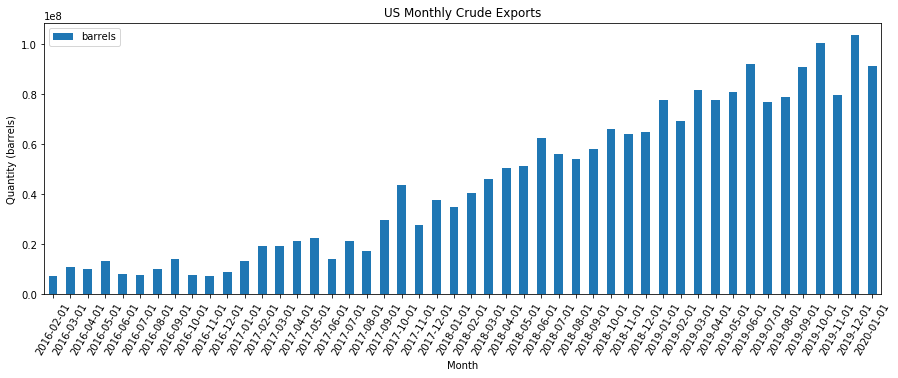

In [12]:
ax = monthly_quantity.plot(kind="bar", 
                           figsize = (15,5), 
                           rot=60,
                           title = "US Monthly Crude Exports")
ax.set_ylabel("Quantity (barrels)")
ax.set_xlabel("Month")

## Grades Breakdown

In [13]:
quantity_by_category = cms.groupby(by = ["loading_month","product_category"]).\
                           agg({"quantity": "sum"}).\
                           rename(columns = {"quantity": "barrels"}).\
                           reset_index()
quantity_by_category = quantity_by_category.pivot(index = "loading_month", 
                                                  columns = "product_category",
                                                  values = "barrels")
quantity_by_category = quantity_by_category.fillna(0)
quantity_by_category.head()

product_category,Heavy-Sour,Light-Sour,Light-Sweet,Medium-Sour,Medium-Sweet
loading_month,,,,,
2016-02-01,0.0,0.0,6365508.0,0.0,0.0
2016-03-01,0.0,0.0,9770342.0,0.0,550011.0
2016-04-01,0.0,0.0,8568627.0,0.0,397395.0
2016-05-01,0.0,0.0,10014700.0,986121.0,0.0
2016-06-01,0.0,0.0,4516795.0,435939.0,142074.0


Text(0.5, 0, 'Month')

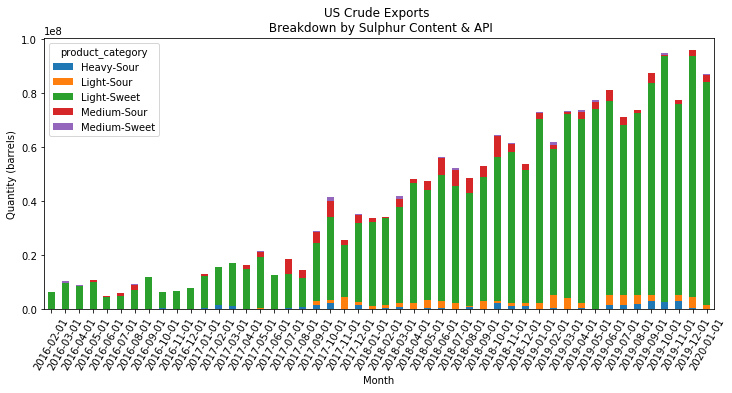

In [14]:
ax2 = quantity_by_category.plot.bar(stacked=True, 
                                    figsize = (12,5), 
                                    rot = 60,
                                    title = "US Crude Exports \n Breakdown by Sulphur Content & API")
ax2.set_ylabel("Quantity (barrels)")
ax2.set_xlabel("Month")

## Top Destinations

Who are the main **receivers** of US crude starting from 2019 onwards?

In [15]:
NUM_TOP_DESTINATIONS = 10

# Filter all movements taht started from 2019 onwards
cms_2019 = cms.loc[cms["start_timestamp"] >= "2019-01-01"]

# Calculate quantity per destination
quantity_per_destination = cms_2019.groupby("unloading_country").\
                                    agg({"quantity": "sum"}).\
                                    sort_values(by = "quantity", ascending = False)

# Select top destinations and group together the remaining ones
top_destination_countries = quantity_per_destination.head(NUM_TOP_DESTINATIONS)
rest = pd.DataFrame(index = ["Other"], columns = ["quantity"])
rest.loc["Other"] = quantity_per_destination[NUM_TOP_DESTINATIONS:].sum().values
top_destination_countries = pd.concat([top_destination_countries, rest])
top_destination_countries["perc"] = round(top_destination_countries["quantity"]*100 / top_destination_countries["quantity"].sum(),2)

display(top_destination_countries)

,quantity,perc
South Korea,153905980,14.28
Canada,127674691,11.85
United Kingdom,104732663,9.72
Netherlands,101635941,9.43
India,88944646,8.26
Taiwan,52528474,4.88
Italy,49238741,4.57
China,41709018,3.87
France,41032695,3.81
Thailand,30040471,2.79


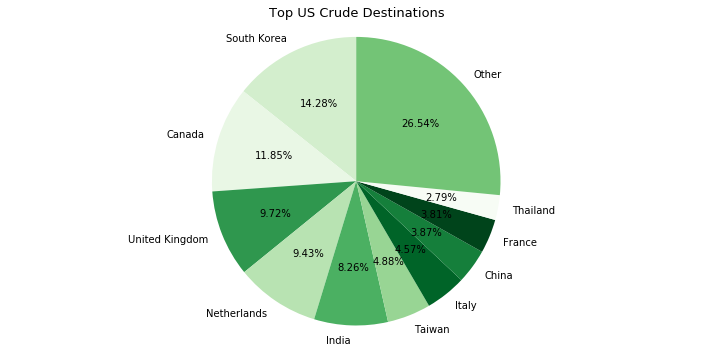

In [16]:
# Pick a colormap pallette and generate random colors
vals = np.linspace(0,1,top_destination_countries.shape[0])
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.Greens(vals))

plt.figure(figsize = (10,5))
plt.pie(top_destination_countries["quantity"],
        labels = top_destination_countries.index.values,
        shadow = False,
        colors = cmap.colors,
        startangle=90,
        autopct = "%1.2f%%")
plt.title("Top US Crude Destinations", fontsize=13)
plt.axis("equal")
plt.tight_layout()

# Simple Forecasting Model

Having done an initial exploration of the US crude exports, now is time to make it even more interesing and see how an analyst or data scientist could use these data to build a predictive model. For this purpose, we will try to predict **future** flows using an open source library called **Prophet** that was developed by Facebook. Although there is no free-lunch, Prophet is a very intuitive library, offers quick and handy results and is ideal for an initial iteration / baseline models on a wide variety of forecasting problems.

It is based on a `Generalized Additive Model (GAM)` with three main components: `trend`, `seasonality` and `holidays`:
$$ y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$$

For the purposes of this notebook, we will use the default parameters to fit our model. In order to install Prophet, you can simply run `pip install fbprophet` or `conda install -c conda-forge fbprophet` for conda users.

In [17]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


Firstly, we need to prepare our DataFrame. The input to Prophet must always be a DataFrame with two columns: `ds` (datestamp in Pandas expected format) and `y` (numerical value to be predicted). 

In [18]:
df = monthly_quantity.copy().reset_index()
df = df.rename(columns = {"loading_month": "ds", "barrels": "y"})
df.tail()

,ds,y
43,2019-09-01,91128679
44,2019-10-01,100686490
45,2019-11-01,79899088
46,2019-12-01,103536412
47,2020-01-01,91491919


## Model Fitting and Cross-Validation

We can now initialize and fit our model. Since we will deal with monthly data we explicitly ignore weekly seasonality.

In [19]:
m = Prophet(weekly_seasonality=False)
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet offers a built-in method for cross-validation using *simulated historical forecasts (SHFs)*. What this  essentially does is to select some *cutoff* points in the history, for each of them fit a model using data only up to the cutoff point and then make predictions for a given forecast horizon. The user needs to specify the `horizon (H)` and optionally the size of the `initial` training period and the `period` (i.e. spacing) between the cutoff dates. As a heuristic, for a given horizon `H` it is suggested that a simulated forecast runs every `H/2` periods. Since we are dealing with monthly data we will set our initial training size to 2 years (24 months) to be able to account for yearly seasonality, our forecasted horizon to 6 months and the period to 3 months.

One important thing to notice is the following: Prophet's build-in `cross_validation` method accepts period arguments that are **timedelta** objects. In this notebook, we are dealing with monthly data, however, pandas latest version (i.e. **1.0.1**) doesn't seem to work with a month unit in the `pd.to_timedelta` method (although pandas docs mention that an `M` option is supported as a unit, the following error pops-up when trying to run: *ValueError: Units 'M' and 'Y' are no longer supported, as they do not represent unambiguous timedelta values durations*). A work-around through this is to define periods in days and multiply by the **average number of days per month**, as defined in the Gregorian calendar (i.e. 30.436875). With this conversion the results will be identical with what `pd.to_timedelta()` with `unit=''M` would produce in older pandas versions.

In [20]:
# Define initial training size, horizon and period
days_per_month = 30.436875
CV_INITIAL_SIZE = 24*days_per_month
CV_PERIOD_SIZE = 3*days_per_month
CV_HORIZON_SIZE = 6*days_per_month

# Run cross validation
df_cv = cross_validation(m, initial = pd.to_timedelta(CV_INITIAL_SIZE, unit="D"),
                            period = pd.to_timedelta(CV_PERIOD_SIZE, unit="D"),
                            horizon = pd.to_timedelta(CV_HORIZON_SIZE, unit="D"))
df_cv["cutoff"] = pd.to_datetime(df_cv["cutoff"].dt.date)
df_cv

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-04-01 19:48:54 and 2019-07-02 09:05:24
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-05-01,5.040042e+07,4.967177e+07,5.112307e+07,51396720,2018-04-01
1,2018-06-01,3.664930e+07,3.587002e+07,3.751328e+07,62484612,2018-04-01
2,2018-07-01,4.853681e+07,4.763286e+07,4.957673e+07,56289465,2018-04-01
3,2018-08-01,3.523361e+07,3.413859e+07,3.646861e+07,54322880,2018-04-01
4,2018-09-01,5.316111e+07,5.186468e+07,5.469529e+07,58102768,2018-04-01
5,2018-10-01,8.382423e+07,8.210670e+07,8.572572e+07,66206919,2018-04-01
6,2018-08-01,3.750728e+07,3.495334e+07,4.019379e+07,54322880,2018-07-02
7,2018-09-01,5.491614e+07,5.214068e+07,5.755979e+07,58102768,2018-07-02
8,2018-10-01,8.613946e+07,8.326978e+07,8.882009e+07,66206919,2018-07-02
9,2018-11-01,5.251827e+07,4.998365e+07,5.516644e+07,64247100,2018-07-02


In the above DataFrame, we can see all the predicted values per cutoff point along with the uncertainty intervals. To illustrate this in a more clear manner, we will plot the actual and predicted values for all the simulated historical forecasts.

In [21]:
def plot_predictions(m, df_cv):
    """ 
    Plots actual and predicted values for all different cutoff points 
    Input args:
                m: Prophet fitted model
                df_cv: Output DataFrame of Prophet cross_validation method
    """
    i=1
    # Iterate through the cutoff points
    for ct in df_cv["cutoff"].unique():
        dfs = df_cv.loc[df_cv["cutoff"] == ct]
        fig = plt.figure(facecolor="w", figsize=(8, 4))
        ax = fig.add_subplot(111)
        ax.plot(m.history["ds"].values, m.history["y"], "k.")
        ax.plot(dfs["ds"].values, dfs["yhat"], ls = "-", c = "#0072B2")
        ax.fill_between(dfs["ds"].values, dfs["yhat_lower"], dfs["yhat_upper"], color = "#0072B2", alpha = 0.4)
        ax.axvline(x=pd.to_datetime(ct), c = "gray", lw = 4, alpha = 0.5)
        ax.set_title("Cutoff date: {} \n Training set size: {} months".\
                     format(pd.to_datetime(ct).date(), int((CV_INITIAL_SIZE + i*CV_PERIOD_SIZE) / days_per_month)))
        ax.set_ylabel("Quantity")
        ax.set_xlabel("Date")
        i+=1
        
        
def get_cv_performance_metrics(df_cv):
    """ 
    Calculate basic performance metrics for the cross-validated results 
    Input args:
                df_cv: Output DataFrame of Prophet cross_validation method
    """
    dfp = performance_metrics(df_cv)
    dfpg = dfp.copy()
    dfpg["horizon_days"] = dfpg["horizon"].map(lambda x: round(x.days,-1))
    dfpg = dfpg.groupby("horizon_days").agg({"horizon": "first",
                                             "rmse": "mean",
                                             "mae": "mean",
                                             "mape": "mean",
                                             "coverage": "mean"}).\
                                         reset_index(drop=True)
    return dfp, dfpg

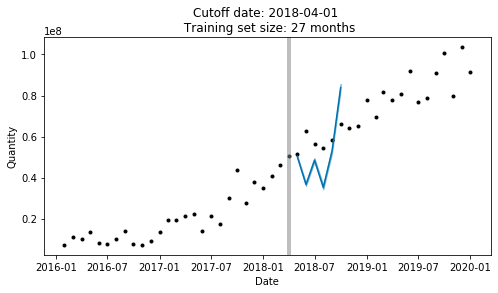

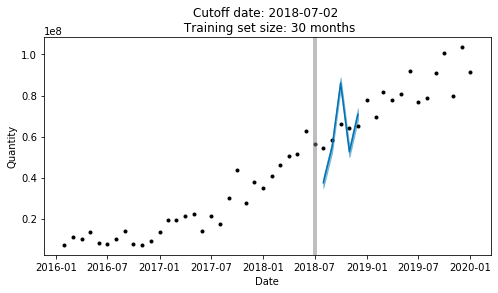

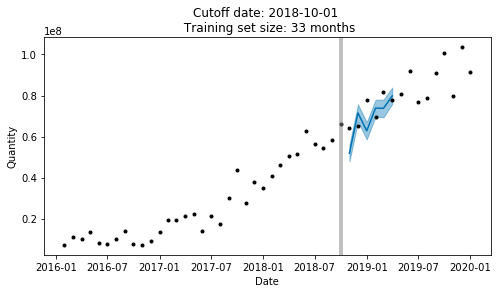

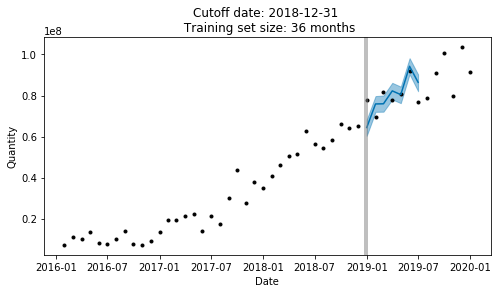

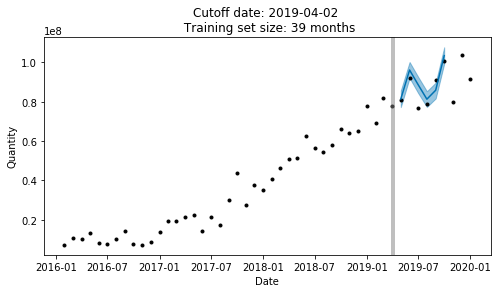

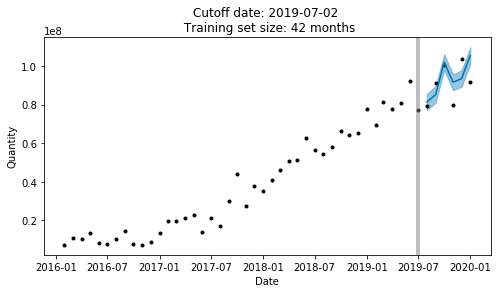

In [22]:
plot_predictions(m, df_cv)

Finally, let's extract some useful statistics for the prediction performance. We will look specifically on the performance of the model for various horizon sizes.

In [23]:
dfp, dfpg = get_cv_performance_metrics(df_cv)
display(dfpg)

,horizon,rmse,mae,mape,coverage
0,30 days,1.014294e+07,7.943737e+06,0.132822,0.222222
1,60 days,9.612280e+06,7.865447e+06,0.113435,0.166667
2,90 days,1.215714e+07,9.925678e+06,0.144349,0.138889
3,121 days,1.184559e+07,1.033440e+07,0.158360,0.222222
4,151 days,7.461642e+06,6.733523e+06,0.089686,0.138889
5,182 days,9.629865e+06,8.470354e+06,0.109512,0.444444


Text(0.5, 1.0, 'Cross-Validated MAPE for various horizon sizes')

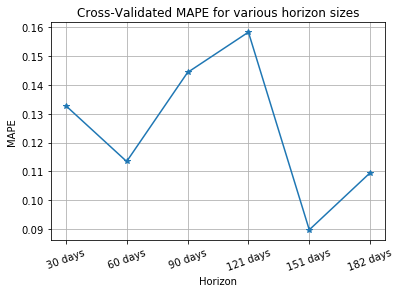

In [24]:
# Plot MAPE with respect to horizon
plt.figure(figsize = (6,4))
plt.plot(dfpg["mape"], "*-")
labels = [str(h.days) + " days" for h in dfpg["horizon"]]
plt.xticks(np.arange(len(dfpg)), labels = labels, rotation = 20)
plt.grid()
plt.xlabel("Horizon")
plt.ylabel("MAPE")
plt.title("Cross-Validated MAPE for various horizon sizes")

As can be seen from the above MAPE plot, using 3.5 years of Vortexa's US Crude export data and a basic forecasting model with default settings and no parametrization we were able to predict exports in a 6 month horizon with MAPE up to 8%. Not bad at all! 

## Make Future Predictions

After the cross-validation we can now move to the final and most exciting part. Finally, let's predict how much crude oil United States will export in the upcoming 6 months.

In [25]:
# Create a DataFrame with future dates
MONTHS_AHEAD_TO_PREDICT = 6
future = m.make_future_dataframe(periods = MONTHS_AHEAD_TO_PREDICT, freq = "MS")
future.tail(MONTHS_AHEAD_TO_PREDICT)

,ds
48,2020-02-01
49,2020-03-01
50,2020-04-01
51,2020-05-01
52,2020-06-01
53,2020-07-01


In [26]:
# Make predictions
forecast = m.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(MONTHS_AHEAD_TO_PREDICT)

,ds,yhat,yhat_lower,yhat_upper
48,2020-02-01,1.029069e+08,9.815953e+07,1.073748e+08
49,2020-03-01,1.088316e+08,1.040407e+08,1.135400e+08
50,2020-04-01,1.113489e+08,1.067104e+08,1.160252e+08
51,2020-05-01,1.148086e+08,1.098006e+08,1.197779e+08
52,2020-06-01,1.081688e+08,1.035143e+08,1.131841e+08
53,2020-07-01,1.140947e+08,1.094229e+08,1.191747e+08


Text(0.5, 33.0, 'Date')

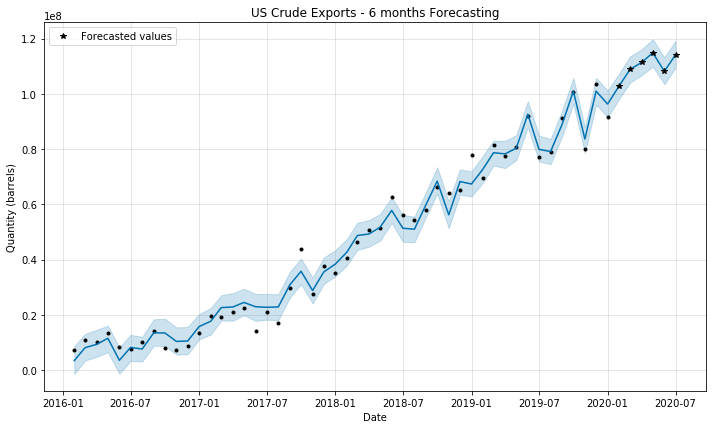

In [27]:
# Plot forecasts along with historical data
fig = m.plot(forecast)
plt.plot(forecast.set_index("ds")["yhat"].tail(MONTHS_AHEAD_TO_PREDICT), "*", color = "black", label = "Forecasted values")
plt.legend(loc = "upper left")
plt.title("US Crude Exports - {} months Forecasting".format(MONTHS_AHEAD_TO_PREDICT))
plt.ylabel("Quantity (barrels)")
plt.xlabel("Date")

In [28]:
#fig2 = m.plot_components(forecast)

# Conclusion

For a baseline model with practically no fine tuning at all, the results look promising. Those data combined with additional regressors from the SDK (e.g. diesel exports from Rotterdam or crude exports from Russia) or even with proprietary data can create even more powerful models and shed light to the future patterns and trends of the global oil seaborne flows. Hoped you enjoyed!